In [64]:
import numpy as np
import itertools
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

import matplotlib.pyplot as plt

from fragenum import molenum
from fragenum import mol_helper
# GraphSet.converters["to_graph"]=nx.Graph
# GraphSet.converters["to_edges"]=nx.Graph.edges

In [2]:
import pickle

# 原子の数のタプルとそれに対するSMILESのset
with open("ProcessedData/3884_smilies.pkl","rb") as f:
    span_mol_dict=pickle.load(f)

iupac_name: 1,1,1-trifluoroethane
molecular_formula: C2H3F3
weight: 84.03999999999999
SMILES: [H]C([H])([H])C(F)(F)F


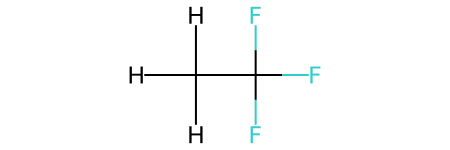

In [86]:
# データを読み込む
ms_pcp_interp=pd.read_pickle("ProcessedData/ms_pcp_interp.pkl")

i=3
# 1つのデータについてみてみる。
a_ms_data=ms_pcp_interp.iloc[i,:]
print("iupac_name:",a_ms_data["iupac_name"])
print("molecular_formula:",a_ms_data["molecular_formula"])
mol=mol_helper.smi_to_mol(a_ms_data["canonical_smiles"])
print("weight:",Descriptors.MolWt(mol))
smiles=Chem.MolToSmiles(mol)
print("SMILES:",smiles)

display(mol)

In [87]:
atm_str_list=[]
atm_strs=["C","H","F","Cl"]
for atm in mol.GetAtoms():
    atm_str_list.append(atm.GetSymbol())

# 原子の数のarray
atm_num_array=np.zeros(4,int)
# あり得るフラグメントを列挙するために
# 原子の数について
# 直積を取るときに使うリスト
comb_list=[]
for j,atm_str in enumerate(atm_strs):
    atm_num=atm_str_list.count(atm_str)
    atm_num_array[j]=atm_num
    comb_list.append(range(atm_num+1))

comb_iter=itertools.product(*comb_list)

frag_res_smi=[]
# あり得るフラグメントを列挙するために
# 原子の数の組み合わせを列挙する(直積)
for j,comb in enumerate(comb_iter):
    # 残りの原子はまた別のフラグメントになっているはずである。
    res=tuple(atm_num_array-comb)
    
    frag_smis=span_mol_dict[comb]
    if len(frag_smis) == 0:
        continue
    res_smis=span_mol_dict[res]
    if len(res_smis) == 0:
        continue
    frag_res_smi.append((frag_smis,res_smis))

In [88]:
frag_data=[]
for frag_res_sets in frag_res_smi:
    for comb in itertools.product(*frag_res_sets):
        frag_mol=mol_helper.smi_to_mol(comb[0])
        res_mol=mol_helper.smi_to_mol(comb[1])
        
        weight=Descriptors.MolWt(frag_mol)
        weight=int(np.round(weight,0))
        
        data_dict={
            "source_mol_no":i,
            "source":mol,
            "source_smiles":smiles,
            "fragment":frag_mol,
            "frag_smiles":comb[0],
            "frag_weight":weight,
            "residual":res_mol,
            "res_smiles":comb[1],
            "intensity":a_ms_data[weight]}
        frag_data.append(data_dict)

RDKit WARNING: [07:52:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:52:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:52:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:52:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:52:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:52:15] WARNING: not removing hydrogen atom without neighbors


In [91]:
df=pd.DataFrame(frag_data)

In [90]:
desc_list = Descriptors.descList

In [92]:
# フラグメントのデータについて記述子を計算
desc_data=[]
invalid_desc_set=set()
for index,row in df.iterrows():
    frag_mol=row["fragment"]
    desc_dict={}
    for desc,func in desc_list:
        try:
            desc_dict[desc]=func(frag_mol)
        except:
            # エラーが発生したものについてはpd.NAを代入
            invalid_desc_set.add(desc)
            desc_dict[desc]=pd.NA
    desc_data.append(desc_dict)

RDKit WARNING: [07:54:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:54:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:54:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:54:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:54:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:54:55] WARNING: not removing hydrogen atom without neighbors


In [97]:
frag_desc_df=pd.DataFrame(desc_data)
# 欠損値のある列を削除する
frag_desc_df=frag_desc_df.dropna(how="any",axis=1)

# 有効な値が入っている記述子のみ抽出する
eff_desc_list=[]
frag_rename_dict={}
for desc in frag_desc_df:
    if frag_desc_df[desc].std() >0:
        eff_desc_list.append(desc)
        frag_rename_dict[desc]="frag_"+desc
        
frag_desc_df=frag_desc_df[eff_desc_list]     
frag_desc_df=frag_desc_df.rename(columns=frag_rename_dict)

In [100]:
# もう片方のフラグメントのデータについて記述子を計算
desc_data=[]
invalid_desc_set=set()
for index,row in df.iterrows():
    res_mol=row["residual"]
    desc_dict={}
    for desc,func in desc_list:
        try:
            desc_dict[desc]=func(res_mol)
        except:
            invalid_desc_set.add(desc)
            desc_dict[desc]=pd.NA
    desc_data.append(desc_dict)

RDKit WARNING: [07:59:57] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:59:57] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:59:57] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:59:57] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:59:57] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [07:59:57] WARNING: not removing hydrogen atom without neighbors


In [101]:
res_desc_df=pd.DataFrame(desc_data)
res_desc_df=res_desc_df.dropna(how="any",axis=1)

eff_desc_list=[]
res_rename_dict={}
for desc in res_desc_df:
    if res_desc_df[desc].std() >0:
        eff_desc_list.append(desc)
        res_rename_dict[desc]="res_frag_"+desc
        
res_desc_df=res_desc_df[eff_desc_list]        
res_desc_df=res_desc_df.rename(columns=res_rename_dict)

In [103]:
whole_data=pd.concat([df,frag_desc_df,res_desc_df],axis=1)

In [105]:
null_data=whole_data.isnull().sum()
for col,val in null_data.iteritems():
    if val>0:
        print(col,val)

In [106]:
X=whole_data[list(frag_rename_dict.values())+list(res_rename_dict.values())].values
Y=whole_data["intensity"].values

In [108]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,Y)

LinearRegression()

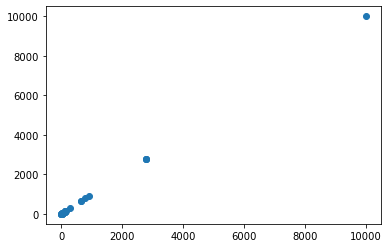

In [109]:
est_intensity=np.maximum(lr.predict(X),0)
plt.plot(Y,est_intensity,'o')

In [104]:
whole_data

,source_mol_no,source,source_smiles,fragment,frag_smiles,frag_weight,residual,res_smiles,intensity,frag_MaxEStateIndex,...,res_frag_VSA_EState8,res_frag_VSA_EState9,res_frag_FractionCSP3,res_frag_HeavyAtomCount,res_frag_NumHeteroatoms,res_frag_NumRotatableBonds,res_frag_MolLogP,res_frag_MolMR,res_frag_fr_alkyl_halide,res_frag_fr_halogen
0,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad6588f0>,[F],19,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658df0>,[H][C]([H])C([H])(F)F,50.0,0.000000,...,-1.673611,0.000000,0.5,4,2,1,1.08559,11.361,2,2
1,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658e40>,[F],19,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658d50>,[H][C](F)C([H])([H])F,50.0,0.000000,...,-5.673611,0.000000,0.5,4,2,1,1.08719,11.383,1,2
2,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658170>,[F],19,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658030>,[H]C([H])([H])[C](F)F,50.0,0.000000,...,-3.166667,0.000000,0.5,4,2,1,1.43479,11.133,0,2
3,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658120>,FF,38,<rdkit.Chem.rdchem.Mol object at 0x7f20ad6580d0>,[H]C([H])=C([H])F,0.0,8.000000,...,-1.074074,0.000000,0.0,3,1,0,1.09940,11.305,0,1
4,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658080>,[H],1,<rdkit.Chem.rdchem.Mol object at 0x7f20ad6581c0>,[H]C([H])(F)[C](F)F,0.0,0.000000,...,-3.916667,0.000000,0.5,5,3,1,1.38439,11.434,1,3
5,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad6588a0>,[H],1,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658b20>,[H][C]([H])C(F)(F)F,0.0,0.000000,...,-2.006944,0.000000,0.5,5,3,0,1.38279,11.412,3,3
6,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658b70>,[H],1,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658ad0>,[H][C](F)C([H])(F)F,0.0,0.000000,...,-2.423611,0.000000,0.5,5,3,1,1.38279,11.412,2,3
7,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658a30>,[H]F,20,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658f30>,[H]C(F)=C([H])F,20.0,8.750000,...,0.000000,0.000000,0.0,4,2,0,1.39660,11.356,0,2
8,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad6589e0>,[H]F,20,<rdkit.Chem.rdchem.Mol object at 0x7f20ad658350>,[H]C([H])=C(F)F,20.0,8.750000,...,-1.407407,0.000000,0.0,4,2,0,1.39660,11.356,0,2
9,3,<rdkit.Chem.rdchem.Mol object at 0x7f20ad8ce580>,[H]C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f20ad64b080>,[H][H],2,<rdkit.Chem.rdchem.Mol object at 0x7f20ad64b2b0>,[H]C(F)=C(F)F,30.0,5.000000,...,0.000000,0.000000,0.0,5,3,0,1.69380,11.407,0,3


In [19]:
tuple(atm_num_array)

(2, 0, 3, 3)